In [1]:
import tables
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scikits.bootstrap as boot
from pathlib import Path

In [ ]:
h5_file_path = Path("./self-assembly_data/")

In [3]:
import h5py

In [4]:
SMALL_PLOT_SIZE_MM = (30, 30)
SMALL_PLOT_SIZE_IN = (SMALL_PLOT_SIZE_MM[0] / 25.4, SMALL_PLOT_SIZE_MM[1] / 25.4)

In [5]:
plt.style.use("small-matplotlib.style")
import seaborn as sns
# sns.set_context("talk",rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":24})

sns.set_style("whitegrid",{"grid.color": '.9', 'grid.linestyle': '--','axes.edgecolor': '.6', \
                           'xtick.bottom': True,'ytick.left': True})

In [6]:

def bcierr(x):
    try:
        return boot.ci(x, method='abc', output='errorbar')
    except:
        return np.full((2, x.shape[0]), np.nan)

def calc_cols(arr):
    growthrate_array = arr.cols.invtimes_array[:]
    
    growthrate_array[growthrate_array <= 1.01 * 1/arr.attrs['maxtime']] = np.nan
    
    growthrate_array *= arr.attrs['targetsize']

    speed = growthrate_array.mean(axis=1)
    speed_err = np.apply_along_axis(bcierr, 1, growthrate_array)[:,:,0].T

    nsims = arr.attrs['nsims']
    repscut = (arr.attrs['targetsize'] / 6 - 6)/2
    cutcol = int(3 + repscut*2)


    pd = np.logspace(-8, 0, 1000)
    plow = np.vectorize(lambda k: pd[np.flatnonzero(scipy.stats.binom.sf(k, nsims*repscut, pd) >= 0.05)[0]])
    phigh = np.vectorize(lambda k: pd[np.flatnonzero(scipy.stats.binom.sf(k, nsims*repscut, pd) >= 0.95)[0]])

    mmc = arr.col('mismatch_locs_array')[:,:,:,:cutcol].astype(bool).sum(axis=3).sum(axis=2).sum(axis=1)/2
    mmm = arr.col('mismatch_locs_array')[:,:,:,:cutcol].astype(bool).sum(axis=3).sum(axis=2).mean(axis=1)/2 / repscut

    mmerrs = [np.maximum(mmm-plow(mmc),0), phigh(mmc)-mmm]
    
    growthrate_array.sort(axis=1)
    p5 = np.quantile(growthrate_array, [0.5], axis=1)[0,:]
    qr = np.abs(np.quantile(growthrate_array, [0.05, 0.95], axis=1) - p5)

    
    return {
        'speed': speed,
        'speed_err': speed_err,
        'speed_median': p5,
        'speed_90range': qr,
        'error_rate': mmm,
        'error_rate_err': mmerrs,
    }


In [7]:
evolve_melttime = tables.open_file(h5_file_path / '2023-12-04_sims-evolve-only-melttime-big.h5')#'sims-evolve-melttime.h5', 'r')
system = "stall_error"
t = [evolve_melttime.get_node(f"/{system}/results_{run_number}") for run_number in range(0, 10)]
cc = [calc_cols(tt) for tt in t]

In [8]:
ETL = "evolutionary time"
fcreate = lambda: plt.subplots(figsize=SMALL_PLOT_SIZE_IN, constrained_layout=True)

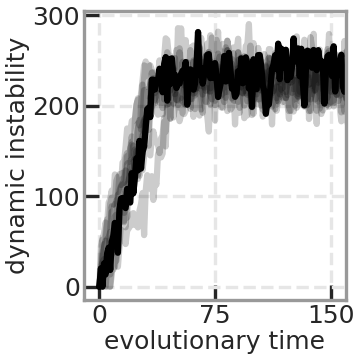

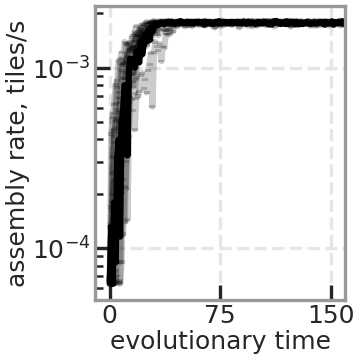

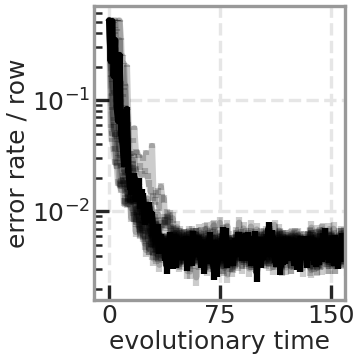

In [9]:
plt.style.use("small-matplotlib.style")
fig, ax = fcreate()
ax.plot(t[1].cols.mutindex, t[1].cols.melttime, color='black')

for i in range(0, len(t)):
    ax.plot(t[i].cols.mutindex, t[i].cols.melttime, color='black', alpha=0.2)

ax.set_xlabel(ETL)
ax.set_ylabel("dynamic instability")
ax.set_xlim(-10, 160)
ax.set_xticks([0, 75, 150])
fig.savefig("figure-plots/fig3-b1-dynamic-instability.pdf")

fig, ax = fcreate()

ax.errorbar(t[1].cols.mutindex, cc[1]['speed'], cc[1]['speed_err'], color='black')
for i in range(0,len(t)):
    ax.errorbar(t[i].cols.mutindex, cc[i]['speed'], cc[i]['speed_err'], color='black', alpha=0.2)
ax.set_yscale("log")
ax.set_xlabel(ETL)
ax.set_ylabel("assembly rate, tiles/s")
ax.set_xlim(-10, 160)
ax.set_xticks([0, 75, 150])
fig.savefig("figure-plots/fig3-b2-assembly-rate.pdf")


fig, ax = fcreate()

ax.errorbar(t[1].cols.mutindex, cc[1]['error_rate'], cc[1]['error_rate_err'], color='black')
for i in range(0,len(t)):
    ax.errorbar(t[i].cols.mutindex, cc[i]['error_rate'], cc[i]['error_rate_err'], color='black', alpha=0.2)
ax.set_yscale("log")
ax.set_xlabel(ETL)
ax.set_ylabel("error rate / row")
ax.set_xlim(-10, 160)
ax.set_xticks([0, 75, 150])
fig.savefig("figure-plots/fig3-b3-error-rate.pdf")



In [10]:
sweep_melttime = tables.open_file(h5_file_path / '2023-11-21_sims-sweep-melt-time-big.h5')


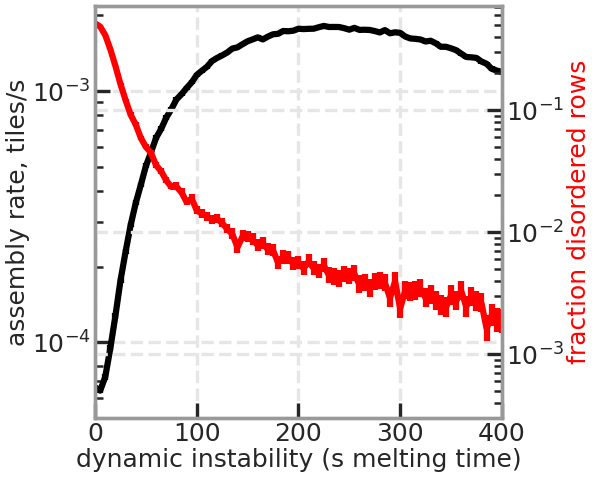

In [11]:
fig, ax = plt.subplots(figsize=(50/25.4,40/25.4), constrained_layout=True)
ax2 = ax.twinx()

r = "stall_error"
sm = sweep_melttime.get_node(f'/{r}/results_8.4')
cc = calc_cols(sm)
ax.errorbar(sm.cols.melttime, cc['speed'], cc['speed_err'], color='black')
ax2.errorbar(sm.cols.melttime, cc['error_rate'], cc['error_rate_err'], color='red')

# r = "stall_noerror"
# sm = sweep_melttime.get_node(f'/{r}/results_8.4')
# cc = calc_cols(sm)
# ax.errorbar(sm.cols.melttime, cc['speed'], cc['speed_err'], color='black', linestyle='dashed')
# ax2.errorbar(sm.cols.melttime, cc['error_rate'], cc['error_rate_err'], color='red', linestyle='dashed')

# r = "mediumstall_error"
# sm = sweep_melttime.get_node(f'/{r}/results_8.4')
# cc = calc_cols(sm)
# ax.errorbar(sm.cols.melttime, cc['speed'], cc['speed_err'], color='black', linestyle='dotted')
# ax2.errorbar(sm.cols.melttime, cc['error_rate'], cc['error_rate_err'], color='red', linestyle='dotted')


ax.set_yscale('log')
ax.set_xlabel("dynamic instability (s melting time)")
ax.set_ylabel("assembly rate, tiles/s")
ax.set_ylim(5e-5, None)
ax.set_xlim(0, 400)

ax2.set_yscale('log')
ax2.set_ylabel('fraction disordered rows', color='red')
ax2.set_ylim(3e-4, None)

fig.savefig("figure-plots/fig3-a-instability-sweep.pdf")


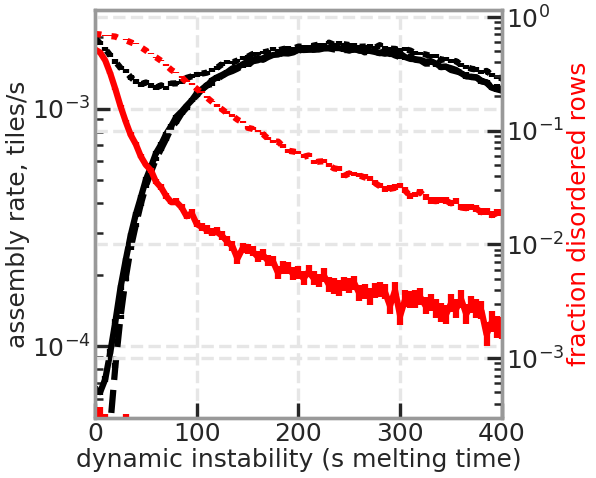

In [12]:
fig, ax = plt.subplots(figsize=(50/25.4,40/25.4), constrained_layout=True)
ax2 = ax.twinx()

r = "stall_error"
sm = sweep_melttime.get_node(f'/{r}/results_8.4')
cc = calc_cols(sm)
ax.errorbar(sm.cols.melttime, cc['speed'], cc['speed_err'], color='black')
ax2.errorbar(sm.cols.melttime, cc['error_rate'], cc['error_rate_err'], color='red')

r = "stall_noerror"
sm = sweep_melttime.get_node(f'/{r}/results_8.4')
cc = calc_cols(sm)
ax.errorbar(sm.cols.melttime, cc['speed'], cc['speed_err'], color='black', linestyle='dashed')
ax2.errorbar(sm.cols.melttime, cc['error_rate'], cc['error_rate_err'], color='red', linestyle='dashed')

r = "mediumstall_error"
sm = sweep_melttime.get_node(f'/{r}/results_8.4')
cc = calc_cols(sm)
ax.errorbar(sm.cols.melttime, cc['speed'], cc['speed_err'], color='black', linestyle='dotted')
ax2.errorbar(sm.cols.melttime, cc['error_rate'], cc['error_rate_err'], color='red', linestyle='dotted')


ax.set_yscale('log')
ax.set_xlabel("dynamic instability (s melting time)")
ax.set_ylabel("assembly rate, tiles/s")
ax.set_ylim(5e-5, None)
ax.set_xlim(0, 400)

ax2.set_yscale('log')
ax2.set_ylabel('fraction disordered rows', color='red')
ax2.set_ylim(3e-4, None)

fig.savefig("figure-plots/si-fig-instability-sweep-full.pdf")


In [13]:
sweep_noinst_growtemp = tables.open_file(
    h5_file_path / "2023-11-24_sims-sweep-growth-temperature-big-nofilter.h5"
)

/home/const/Development/venv-standard/lib64/python3.12/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in _nppf_py (vectorized)
  outputs = ufunc(*inputs)


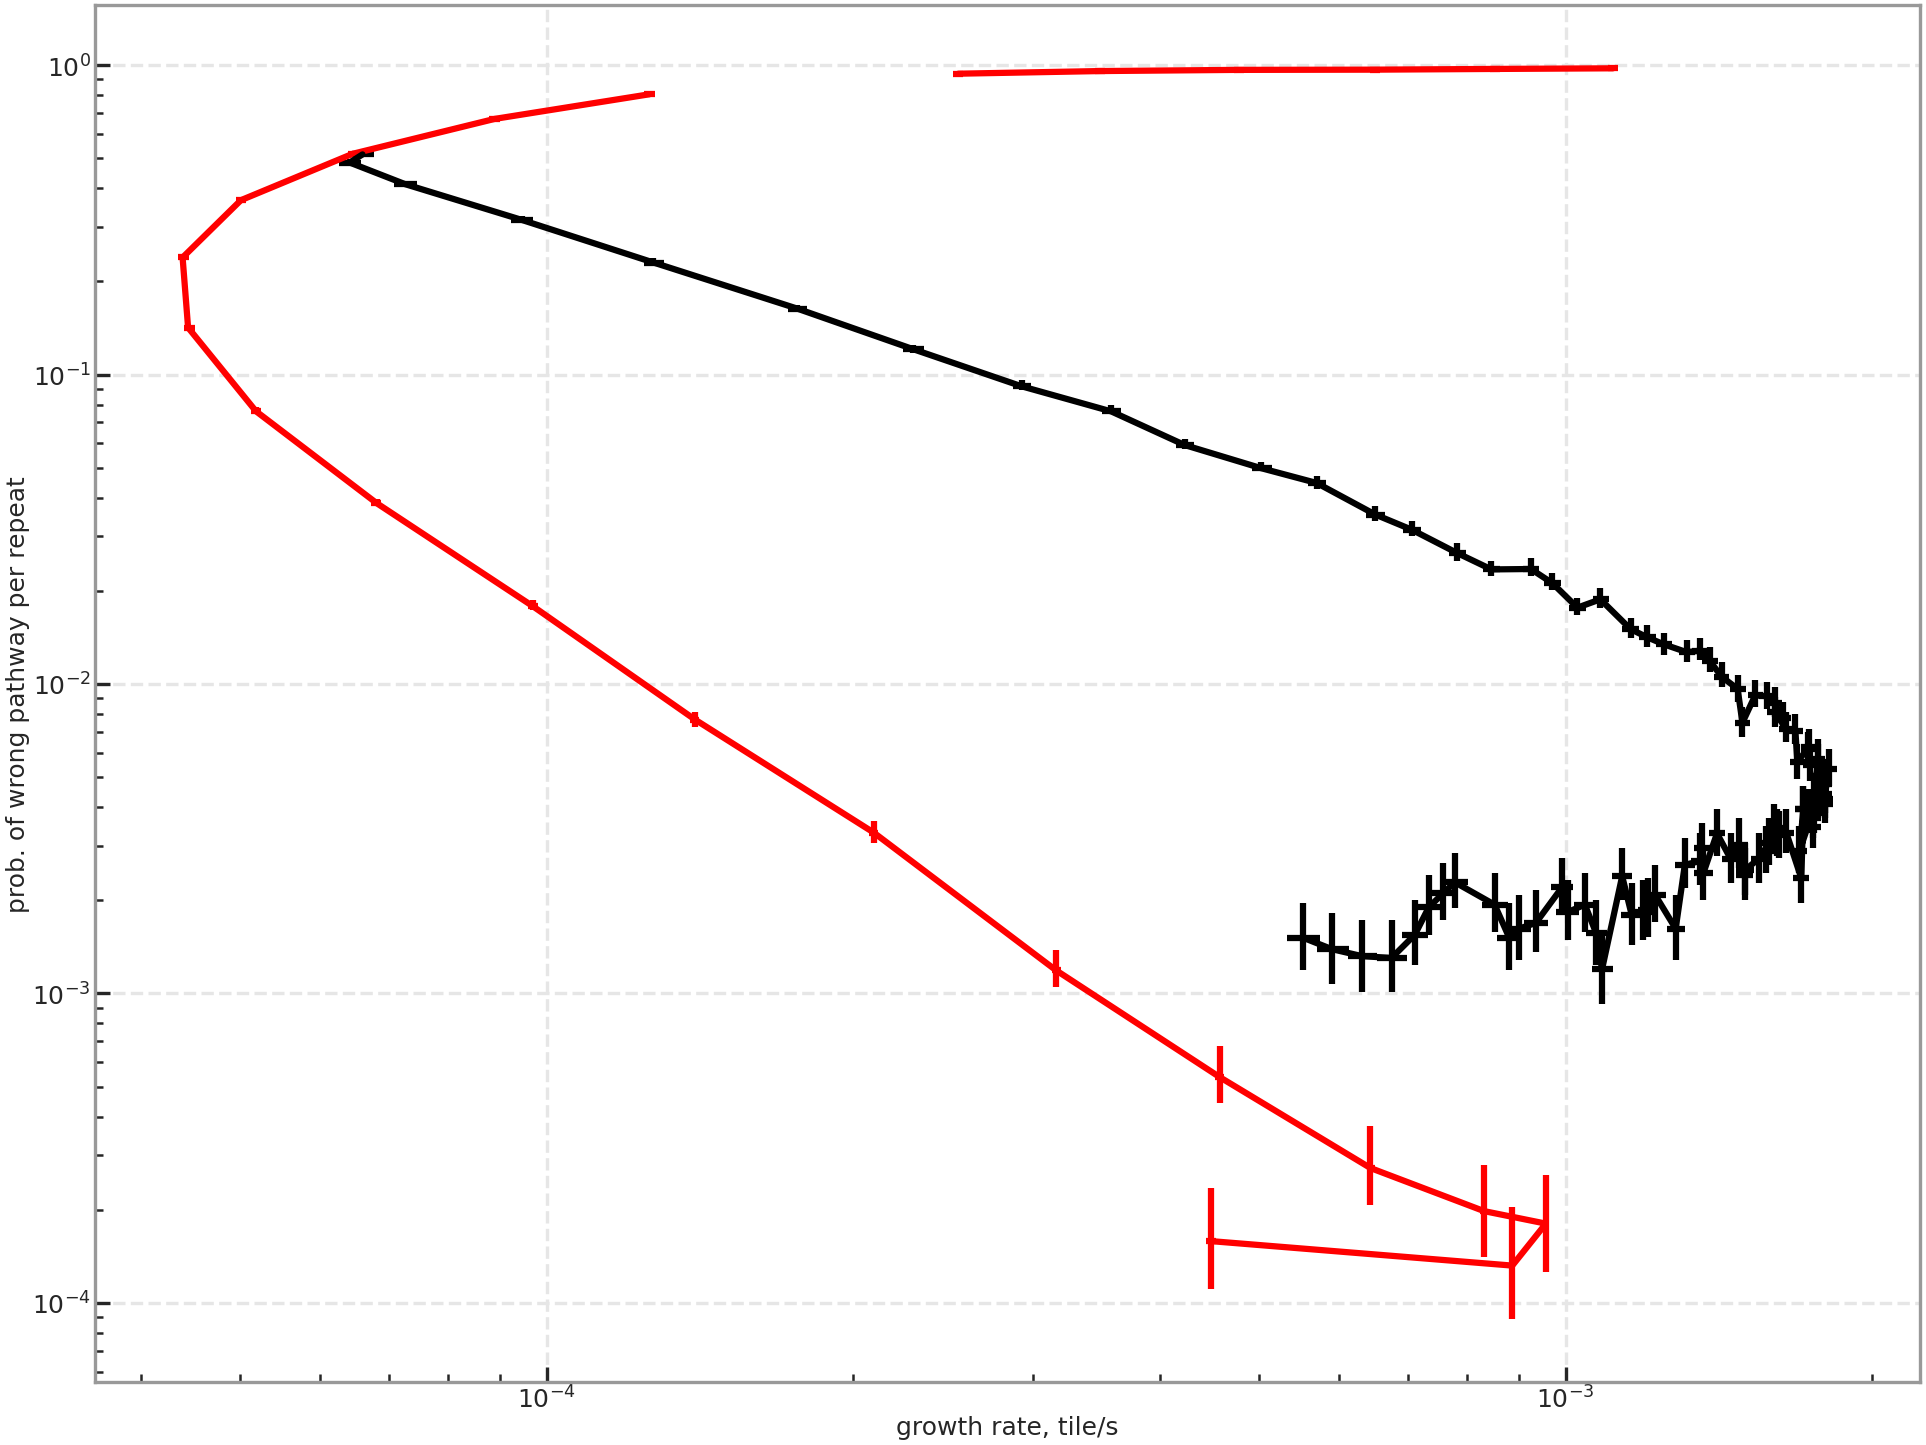

In [14]:
ds = "stall_error"

ccm = calc_cols(sweep_noinst_growtemp.get_node(f'/{ds}/results'))
plt.errorbar(ccm['speed'], ccm['error_rate'], ccm['error_rate_err'], ccm['speed_err'], color='red')

cci = calc_cols(sweep_melttime.get_node(f'/{ds}/results_8.4'))
plt.errorbar(cci['speed'], cci['error_rate'], cci['error_rate_err'], cci['speed_err'], color='black')

plt.yscale('log')
plt.xscale('log')
plt.ylabel("prob. of wrong pathway per repeat")
plt.xlabel("growth rate, tile/s")

plt.savefig(f"{ds}-errors-vs-speed.pdf")

In [17]:
60*60*ccm['speed'][(ccm['error_rate'] < 0.01) & ~np.isnan(ccm['speed'])].max()

3.4430896708114798

In [18]:
60*60*cci['speed'][(cci['error_rate'] < 0.01) & ~np.isnan(cci['speed'])].max(),


(6.531996857695248,)

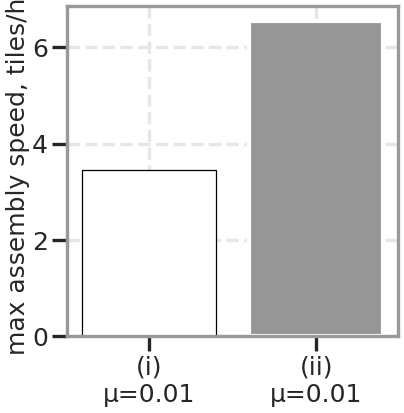

In [2]:
import palettable as pal
import matplotlib.pyplot as plt
plt.style.use("small-matplotlib.style")
import seaborn as sns
# sns.set_context("talk",rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":24})

sns.set_style("whitegrid",{"grid.color": '.9', 'grid.linestyle': '--','axes.edgecolor': '.6', \
                           'xtick.bottom': True,'ytick.left': True})

fig, ax = plt.subplots(figsize=(33/25.4,35/25.4), layout='constrained')
ax.bar(
    [0],
    [
       3.4430896708114798 # 60*60*ccm['speed'][(ccm['error_rate'] < 0.01) & ~np.isnan(ccm['speed'])].max(),
    ], color='white', edgecolor='black', linewidth=0.3)
ax.bar(
    [1],
    [
       6.531996857695248 # 60*60*cci['speed'][(cci['error_rate'] < 0.01) & ~np.isnan(cci['speed'])].max(),
    ], color=pal.colorbrewer.sequential.Greys_6.mpl_colors[3])
ax.set_xticks([0, 1])
ax.set_xticklabels(['(i)\nµ=0.01','(ii)\nµ=0.01'])
ax.set_ylabel("max assembly speed, tiles/hr")
ax.set_position([0.13,0.15,0.85,0.80])
fig.savefig('figure-plots/fig5-b-melting-vs-instability.pdf')